In [1861]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas

Dividimos el dataset en train y test

In [1862]:
from sklearn.model_selection import train_test_split

full_df = pd.read_csv('./airbnb-listings.csv', sep=';', decimal='.')
train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del dataset de training: (11824, 89)
Dimensiones del dataset de test: (2956, 89)


Cargamos en un data frame los datos de train:

# 1. Análisis exploratorio

In [1863]:
df = pd.read_csv('./train.csv', sep=';', decimal='.')

El objetivo del modelo será precedir el precio de un alojamiento de airbnb, por lo que nuestra variable objetivo será 'Price'.
En principio enfocaremos el ejecrcio como un problema de regresión, ya que, aunque airbnb nos proporcione los precios de forma discreta, consideramos que habría demasiadas clases y un modelo de clasificación no es el mejor enfoque. Podríamos utilizar un modelo de clasificación para predecir si el precio de alojamiento estará en cierto intervalo (por ejemplo: barato, medio, caro) pero nosotros intentaremos predecir el precio más exacto posible, es por ello que utilizaremos un modelo de regresión.

In [1864]:
print(f'Número de precios únicos: ',len(np.unique(df.Price)))
df.Price.head()

Número de precios únicos:  353


0     64.0
1     30.0
2     26.0
3     80.0
4    155.0
Name: Price, dtype: float64

Con describe ya vemos que hay algunos missings en el precio porque disminuye su tamaño de 11824 a 11809, aunque analizaremos esto más adelante

In [1865]:
df.Price.describe()

count    11809.000000
mean        73.239648
std         72.130830
min          9.000000
25%         33.000000
50%         55.000000
75%         85.000000
max        999.000000
Name: Price, dtype: float64

También observamos una diferencia muy grande en el precio entre el maximo de los 3 primeros cuartiles (85) y el último (999). Comprobemos cuantos alojamientos hay por intervalos de precio:

In [1866]:
#df.Price.value_counts()

freq = 100               # Amplitud de los intervalos
inf = df.Price.min()        # Limite inferior del primer intervalo
dif = (df.Price.min() - df.Price.max()) % freq or freq
sup = df.Price.max() + dif  # Limite superior del último intervalo

intervals = pd.interval_range(
    start=inf,
    end=sup,
    freq=freq,
    name="Intervalo",
    closed="left"
    )

Precios = pd.DataFrame(index=intervals)
Precios["FreqAbs"] = pd.cut(df.Price, bins=Precios.index).value_counts()
Precios

,FreqAbs
Intervalo,
"[9.0, 109.0)",9968
"[109.0, 209.0)",1407
"[209.0, 309.0)",240
"[309.0, 409.0)",90
"[409.0, 509.0)",53
"[509.0, 609.0)",18
"[609.0, 709.0)",14
"[709.0, 809.0)",13
"[809.0, 909.0)",3


Hay muy pocos alojamientos en los intervalos superiores, lo analizaremos más tarde en mayor profundidad para ver si son outliers y eliminarlos del modelo

Quitamos las características con mas del 50% de valores missings pues consideramos que no tenemos datos sufcientes para poder generarlas

In [1867]:
list_porccentaje_missings = round(df.isnull().sum()/train.shape[0]*100)
print(f'Porcentajes de missing sobre total dataset: \n',list_porccentaje_missings)
caract_no_generables = list_porccentaje_missings.where(lambda x : x>50).dropna()
# Eliminamos las columnas con mas del 50% de missing values
df.drop(caract_no_generables.index, axis=1, inplace=True)
print(f'dimensiones eliminadas: \n',caract_no_generables.index)

Porcentajes de missing sobre total dataset: 
 ID                                  0.0
Listing Url                         0.0
Scrape ID                           0.0
Last Scraped                        0.0
Name                                0.0
Summary                             4.0
Space                              26.0
Description                         0.0
Experiences Offered                 0.0
Neighborhood Overview              38.0
Notes                              62.0
Transit                            38.0
Access                             43.0
Interaction                        44.0
House Rules                        35.0
Thumbnail Url                      19.0
Medium Url                         19.0
Picture Url                         0.0
XL Picture Url                     19.0
Host ID                             0.0
Host URL                            0.0
Host Name                           0.0
Host Since                          0.0
Host Location                     

In [1868]:
df.shape

(11824, 80)

Vemos que la mayoria de muestras son para Madrid por lo que el objeto de este modelo será predecir el precio de los alojamientos en la ciudad de Madrid, no extrapolable a otras poblaciones pues el modelo estará entrenado solo con datos relativos a Madrid.

In [1869]:
df['City'].value_counts()

Madrid                                 10591
Barcelona                                233
London                                   103
Paris                                     78
马德里                                       41
Palma                                     37
Alcúdia                                   32
Berlin                                    32
Roma                                      31
New York                                  30
Dublin                                    28
Los Angeles                               26
Brooklyn                                  21
Wien                                      21
Amsterdam                                 20
Madrid, Comunidad de Madrid, ES           16
Rome                                      13
Palma de Mallorca                         13
Washington                                13
Toronto                                   10
Bondi Beach                                9
Chicago                                    9
København 

In [1870]:
df = df[df['City'] == 'Madrid']

In [1871]:
df.shape

(10591, 80)

In [1872]:
df.head().T

,0,2,3,4,5
ID,8308944,14053931,16253767,10464183,16061370
Listing Url,https://www.airbnb.com/rooms/8308944,https://www.airbnb.com/rooms/14053931,https://www.airbnb.com/rooms/16253767,https://www.airbnb.com/rooms/10464183,https://www.airbnb.com/rooms/16061370
Scrape ID,20170407214119,20170407214119,20170407214119,20170407214119,20170407214119
Last Scraped,2017-04-08,2017-04-08,2017-04-08,2017-04-08,2017-04-08
Name,BOHEMIAN HOME - LA LATINA.,Habitacón + wifi con balcon exterior en Chueca,Spacious Loft in Boho Chic area (Madrid center),CHALET 13 (FANTASY),Apartamento Sol II - VALLE NOSTRO
Summary,"Beautiful apartment in La Latina, central Madr...","Lugares de interés: Chueca, Mercado de San Ant...",Very Chilled and spacious apartment located in...,"Magnifico chalet, de tres alturas, situado en ...",This apartment is located 100 meters from Puer...
Space,Beautiful apartment in La Latina in central Ma...,NaN,NaN,Decoracion FANTASY,NaN
Description,"Beautiful apartment in La Latina, central Madr...","Lugares de interés: Chueca, Mercado de San Ant...",Very Chilled and spacious apartment located in...,"Magnifico chalet, de tres alturas, situado en ...",This apartment is located 100 meters from Puer...
Experiences Offered,none,none,none,none,none
Neighborhood Overview,In La Latina neighborhood in central Madrid. R...,NaN,NaN,NaN,NaN


In [1873]:
# Hacemos un drop de todas las columnas que OBVIAMENTE no aportan información relevante
not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 
    'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]


df.drop(not_useful_columns, axis=1, inplace=True)

In [1874]:
# Hacemos un drop de todas las columnas que aportando información quedan fuera del scope
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About','Host Verifications', 'Features', 'Amenities'
]

df.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)

In [1875]:
df.shape

(10591, 43)

In [1876]:
df.head().T

,0,2,3,4,5
Experiences Offered,none,none,none,none,none
Host Since,2011-11-20,2016-07-17,2015-03-16,2012-09-06,2014-12-03
Host Response Time,within an hour,within an hour,within an hour,within a few hours,within an hour
Host Response Rate,100.0,100.0,100.0,96.0,100.0
Street,"Madrid, Comunidad de Madrid 28005, Spain","Justicia, Madrid, Comunidad de Madrid 28004, S...","Madrid, Comunidad de Madrid 28004, Spain","Hortaleza, Madrid, Madrid 28043, Spain","Madrid, Comunidad de Madrid 28013, Spain"
Neighbourhood,NaN,Justicia,NaN,Hortaleza,NaN
Neighbourhood Cleansed,Embajadores,Justicia,Justicia,Canillas,Sol
Neighbourhood Group Cleansed,Centro,Centro,Centro,Hortaleza,Centro
City,Madrid,Madrid,Madrid,Madrid,Madrid
State,Comunidad de Madrid,Comunidad de Madrid,Comunidad de Madrid,Madrid,Comunidad de Madrid


Vamos a elimiar las filas con un precio mayor a 209 porque no tiene muchas muestras en comparación con aquellos aprtamentos con precio inferior a 209 y estaríamos introduciendo un sesgo en el modelo.

In [1877]:
df = df[df['Price'] <= 209]
df.shape[0]

10363

## 1.1 Correlation Matrix

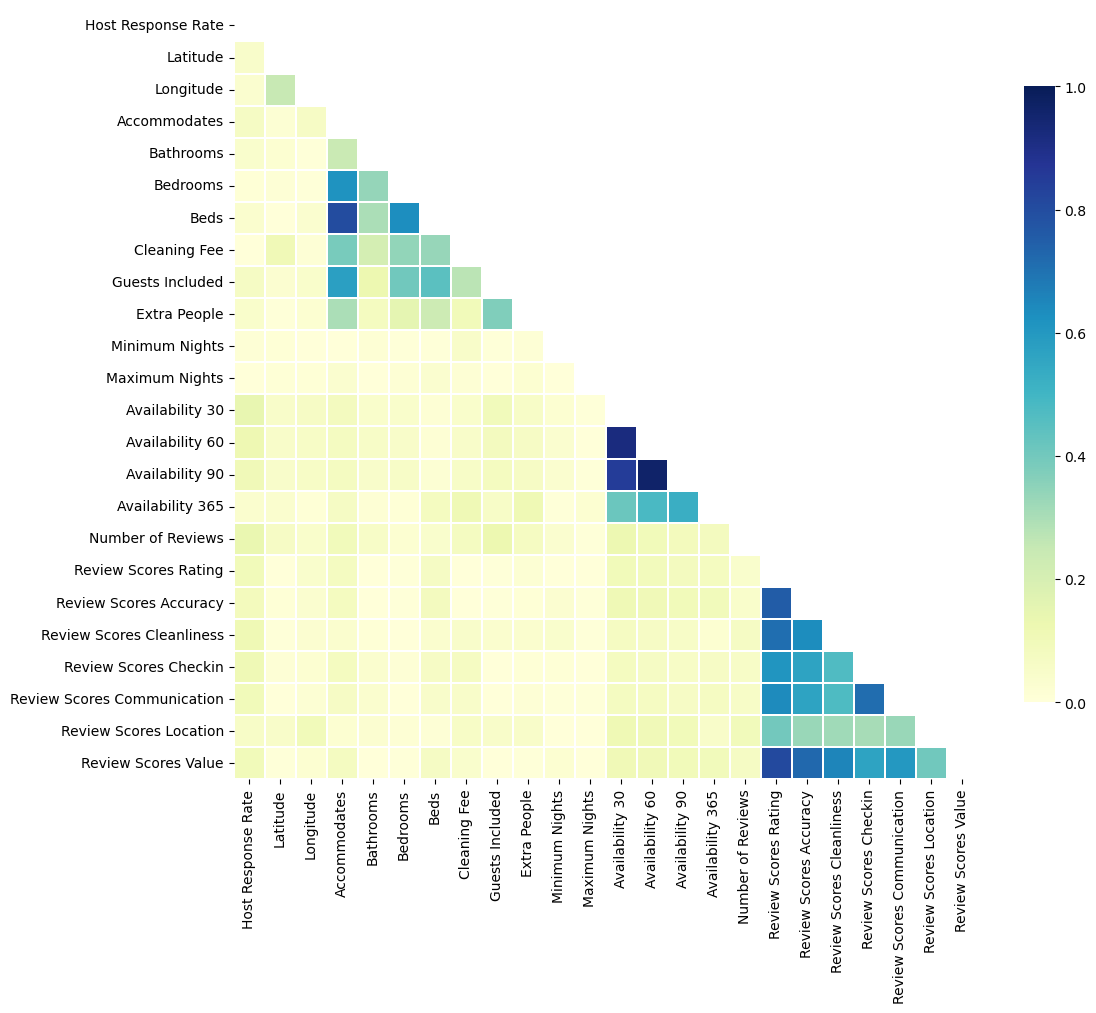

In [1878]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# puedo representar solo la parte inferior ya que es simétrica

Detectamos gran correlación entre:
 - beds y acommodates: Eliminamos acommodate ya que mide practicamente lo mismo que beds, las personas que pueden dormir en el alojamiento.
 - Reviews: 
     - Hemos agrupado las variables con más correlación entre ellas y que miden cosas parecidas. deducimos de los datos que si un alojamiento no está limpio o 
        no encaja con lo publicitado el score rating y value será más bajo y viceversa, por ello las agrupamos.
    - Entre checking y communication ocurre lo mismo, la mayor parte de la omunicación entre host y guest ocurre en el checkin por ellos están tan correlacionadas y también 
        las  agrupamos.
    - Availability 30, 60 y 90 tienen alta correlación, de las tres nos quedamos solo con la de 90. Dejamos tambien la de 365 porque ya no estan tan correlacionadas y creemos que puede influir en el precio que sea un alquiler vacacional (hasta 90) o una vivienda permanente.
 

In [1879]:
# Rango de valores que parece tomar las reviews

columnas = ["Review Scores Rating","Review Scores Value","Review Scores Accuracy", "Review Scores Cleanliness", "Review Scores Checkin","Review Scores Communication", "Review Scores Location"]
for col in columnas:
    minimo = min(df[col])
    maximo = max(df[col])
    print(f'{col}: min= {minimo} max= {maximo} \n')

Review Scores Rating: min= 20.0 max= 100.0 

Review Scores Value: min= 2.0 max= 10.0 

Review Scores Accuracy: min= 2.0 max= 10.0 

Review Scores Cleanliness: min= 2.0 max= 10.0 

Review Scores Checkin: min= 2.0 max= 10.0 

Review Scores Communication: min= 2.0 max= 10.0 

Review Scores Location: min= 2.0 max= 10.0 



normalizamos "Review Scores Rating" pues vamos a hacer operaciones de agregación en las siguientes celdas

In [1880]:
df["Review Scores Rating"] = df["Review Scores Rating"]/10

In [1881]:
# Rango de valores que parece tomar las reviews

columnas = ["Review Scores Rating","Review Scores Value","Review Scores Accuracy", "Review Scores Cleanliness", "Review Scores Checkin","Review Scores Communication", "Review Scores Location"]
for col in columnas:
    minimo = min(df[col])
    maximo = max(df[col])
    print(f'{col}: min= {minimo} max= {maximo} \n')

Review Scores Rating: min= 2.0 max= 10.0 

Review Scores Value: min= 2.0 max= 10.0 

Review Scores Accuracy: min= 2.0 max= 10.0 

Review Scores Cleanliness: min= 2.0 max= 10.0 

Review Scores Checkin: min= 2.0 max= 10.0 

Review Scores Communication: min= 2.0 max= 10.0 

Review Scores Location: min= 2.0 max= 10.0 



In [1882]:
reviews_value_rating = df.loc[: , ["Review Scores Rating","Review Scores Value","Review Scores Accuracy", "Review Scores Cleanliness"]]
df['OverAll Review'] = reviews_value_rating.mean(axis=1)

reviews_comunication = df.loc[: , ["Review Scores Checkin","Review Scores Communication"]]
df['Comunication Review'] = reviews_comunication.mean(axis=1)


df.drop(['Availability 30', 'Availability 60', 'Review Scores Rating','Review Scores Accuracy', "Review Scores Checkin", 
         "Review Scores Communication","Review Scores Cleanliness",
         'Review Scores Value','Accommodates'], axis=1, inplace=True)

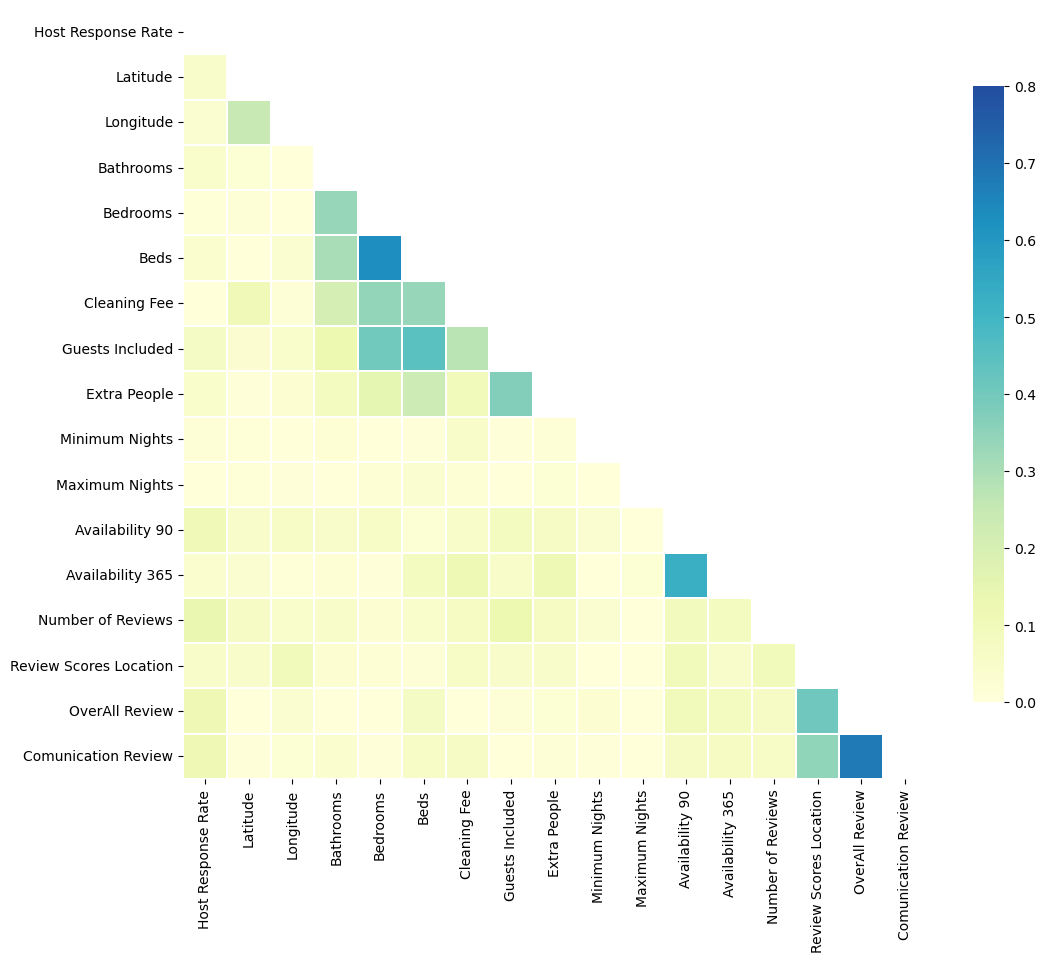

In [1883]:
# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=0.8, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

# La matriz de correlación tiene mejor pinta

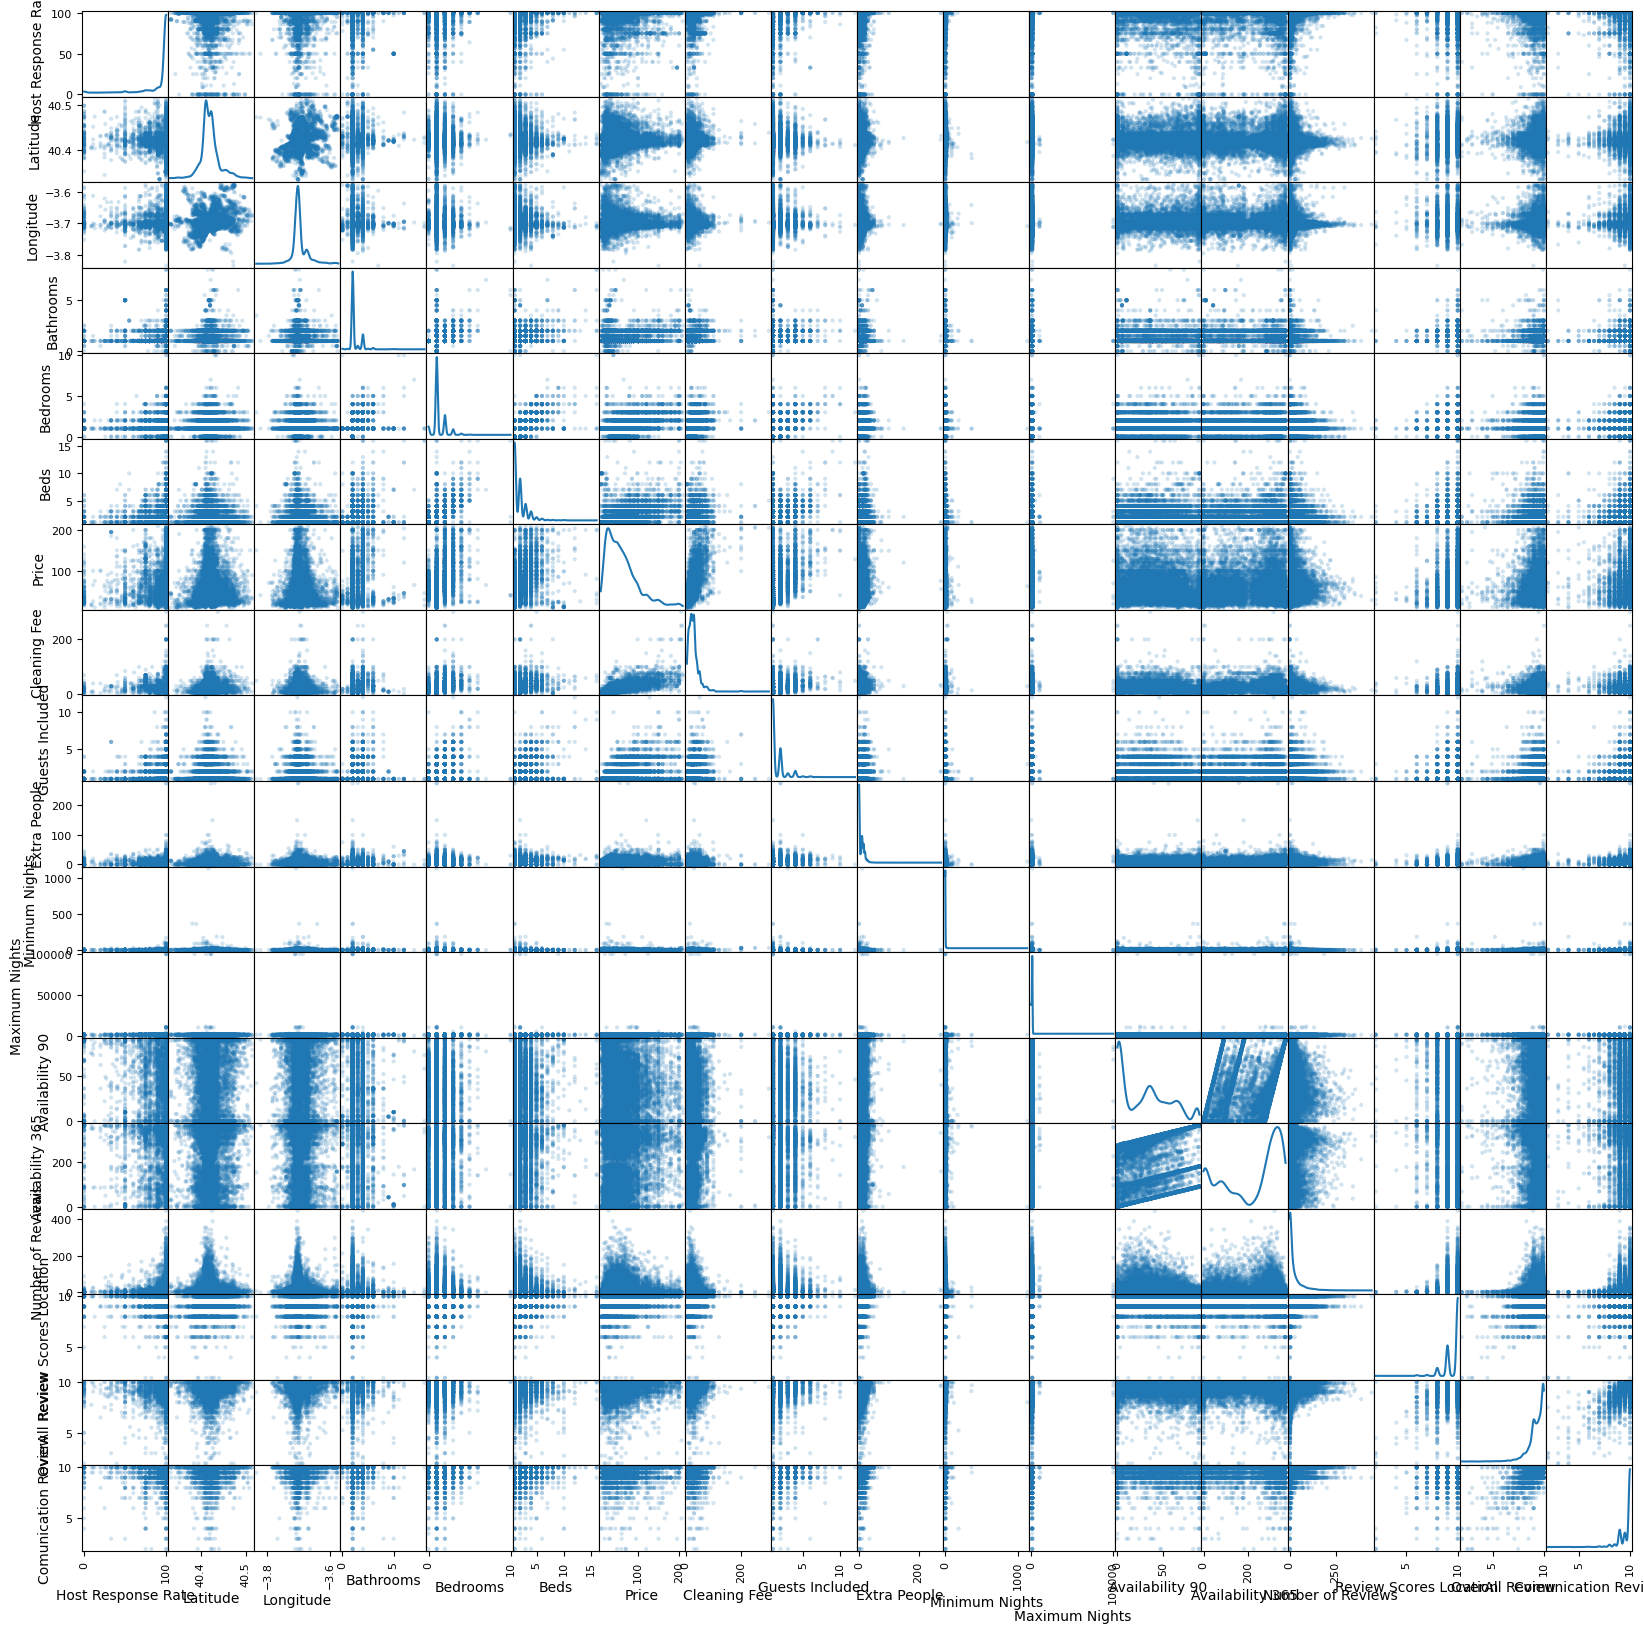

In [1884]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

# 2. Generación de características

In [1885]:
# Por cuestiones prácticas empezamos a trabajar con un nuevo df para no tener que ejecutar todo el código si cometemos un error a partir de aquí.
df_gen = df

Exploramos las dimanesiones que tienn valores missing

In [1886]:
num_missings = round(df.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Host Since                   2.0
Host Response Time        1297.0
Host Response Rate        1297.0
Neighbourhood             3474.0
State                       32.0
Zipcode                    342.0
Market                      36.0
Bathrooms                   34.0
Bedrooms                    19.0
Beds                        34.0
Cleaning Fee              4269.0
Review Scores Location    2217.0
OverAll Review            2195.0
Comunication Review       2201.0
dtype: float64

## 2.1 Reviews
Empezaremos la generación de características por las dimensiones de reviews.
Observamos que hay 2195 muestras con las 3 dimendiones nan, 16 muestras con 1 y 6 muestras con 2 nan.
Generamos las reviews con nan con la media de de los demás campos de la fila que no tengan nan para las muestras que tengan 1 o 2 valores NaN. Para las muestras que tienen los 3 campos NaN, no haremos nada pues nos interesa conocer como se comporta el precio con aquellos alojamientos que no tienen reviews. Para este fin categorizaremos estas variables más adelante.

In [1887]:
reviews =df[['Review Scores Location','OverAll Review','Comunication Review']]
nan_rows = reviews[reviews.isnull().any(1)]

boo_nan = nan_rows.isnull()
#conteo de columnas con nan
boo_nan['nan_colunms'] = boo_nan.sum(axis=1)

boo_nan['nan_colunms'].value_counts()


3    2195
1      16
2       6
Name: nan_colunms, dtype: int64

Creamos un dataframe con las muestras que tenga 1 o 2 NaN y le asignamos el valor medio de la muestra:

In [1888]:
null_columns=reviews.columns[reviews.isnull().any()]
reviews[null_columns].isnull().sum()
df_reviews = reviews[reviews.isnull().any(axis=1)][null_columns]

# df conteo nan por fila
nan_rows = df_reviews[df_reviews.isnull().any(1)]
boo_nan = nan_rows.isnull()
boo_nan['nan_colunms'] = boo_nan.sum(axis=1)
boo_nan

# df merged
reviews_merge = pd.merge(df_reviews,boo_nan,left_index=True, right_index=True)

# quito las filas que todas sean missing
reviews_merge = reviews_merge[reviews_merge['nan_colunms']<3]

# calculo la media de cada fila y la asigno a los missing
columnas = [0,1,2]
for fila in range(len(reviews_merge)):
    valores=[]
    for col in columnas:
        if  False == np.isnan(reviews_merge.iloc[fila,col]):
            valores.append(reviews_merge.iloc[fila,col])
            promedio = sum(valores) / len(valores) 
    for col in columnas:
        if  np.isnan(reviews_merge.iloc[fila,col]):
            reviews_merge.iloc[fila,col] = promedio   
reviews_merge.drop(['Review Scores Location_y','OverAll Review_y','Comunication Review_y','nan_colunms'], axis=1, inplace=True)
reviews_merge.columns = ['Review Scores Location','OverAll Review','Comunication Review']
reviews_merge


,Review Scores Location,OverAll Review,Comunication Review
211,10.000000,10.000000,10.000000
609,8.000000,8.000000,8.000000
1415,9.666667,9.333333,10.000000
1500,10.000000,10.000000,10.000000
1507,3.000000,2.000000,4.000000
1628,10.000000,10.000000,10.000000
2036,10.000000,10.000000,10.000000
2807,7.000000,8.000000,6.000000
3166,10.000000,10.000000,10.000000
3575,10.000000,10.000000,10.000000


incluimos en el dataframe original las característica generadas para las dimensiones de reviews:

In [1889]:
# Sustituimos los nan en el df original por los nuevos valores calculados
for fila in reviews_merge.index:
    #print(fila)
    fila_df_original = df_gen.index.get_loc(fila)
    #print(fila_df_original)
    fila_reviews_merge = reviews_merge.index.get_loc(fila)
    #print(fila_reviews_merge)
    df_gen.iloc[fila_df_original,32]=reviews_merge.iloc[fila_reviews_merge,0]
    df_gen.iloc[fila_df_original,34]=reviews_merge.iloc[fila_reviews_merge,1]
    df_gen.iloc[fila_df_original,35]=reviews_merge.iloc[fila_reviews_merge,2]

Comprobamos que solo quedan valores con 3 NAN:

In [1890]:

reviews =df_gen[['Review Scores Location','OverAll Review','Comunication Review']]
nan_rows = reviews[reviews.isnull().any(1)]

boo_nan = nan_rows.isnull()
#conteo de columnas con nan
boo_nan['nan_colunms'] = boo_nan.sum(axis=1)

boo_nan['nan_colunms'].value_counts()

3    2195
Name: nan_colunms, dtype: int64

## 2.2 Neighbourhood

Hay tres variables con la descripción de barrio, vamos a reducirla solo a una

In [1891]:
df_n = df[['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_n.head(20)

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed
0,NaN,Embajadores,Centro
2,Justicia,Justicia,Centro
3,NaN,Justicia,Centro
4,Hortaleza,Canillas,Hortaleza
5,NaN,Sol,Centro
6,Rios Rosas,Rios Rosas,Chamberí
7,NaN,Sol,Centro
8,Embajadores,Embajadores,Centro
9,NaN,Embajadores,Centro
10,NaN,Almendrales,Usera


In [1892]:
# numero de muestras con valores missing
num_missings = round(df_n.isnull().sum())
num_missings

Neighbourhood                   3474
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
dtype: int64

In [1893]:
# número de valores únicos por dimensión
df_n.apply(lambda x: len(x.unique())) 

Neighbourhood                    66
Neighbourhood Cleansed          125
Neighbourhood Group Cleansed     21
dtype: int64

Nos interesa que el número de muestras por cada barrio esté lo mas equilibrado posible, poer ello nos vamos a quedar con la dimensión 'Neighbourhood Group Cleansed'

In [1894]:
# Recuento de barrios para Neighbourhood Group Cleansed
n_by_Cleansed = df_n.groupby("Neighbourhood Group Cleansed")["Neighbourhood Group Cleansed"].count()
n_by_Cleansed

Neighbourhood Group Cleansed
Arganzuela                629
Barajas                    62
Carabanchel               276
Centro                   5329
Chamartín                 280
Chamberí                  742
Ciudad Lineal             237
Fuencarral - El Pardo     118
Hortaleza                 137
Latina                    286
Moncloa - Aravaca         337
Moratalaz                  60
Puente de Vallecas        174
Retiro                    344
Salamanca                 654
San Blas - Canillejas      99
Tetuán                    365
Usera                     109
Vicálvaro                  27
Villa de Vallecas          36
Villaverde                 62
Name: Neighbourhood Group Cleansed, dtype: int64

Finalmente no tendremos que generar ninguna característica porque la la dimensión seleccionado no tiene valores missing, así que solo vamos a borrar las otras dos dimensiones.

In [1895]:
# Eliminas las dimensiones sobrantes
df_gen.drop(["Neighbourhood", "Neighbourhood Cleansed"], axis=1, inplace=True)

Convertimos la fecha a años de antigüedad del Host en la plataforma

In [1896]:
from datetime import datetime

df_gen.dropna(subset=['Host Since'], inplace=True) # se ha visto antes que solo hay tres valores missing, no se pierde mucho

df_gen['Host Since'] = df['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df_gen['Years Being Host'] = df['Host Since'].apply(lambda x: 2017 - x.year)

df_gen.drop(['Host Since'], axis=1, inplace=True)

In [1897]:
columns_names = df_gen.columns.values
columns_names

array(['Experiences Offered', 'Host Response Time', 'Host Response Rate',
       'Street', 'Neighbourhood Group Cleansed', 'City', 'State',
       'Zipcode', 'Market', 'Smart Location', 'Country Code', 'Country',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Price', 'Cleaning Fee',
       'Guests Included', 'Extra People', 'Minimum Nights',
       'Maximum Nights', 'Availability 90', 'Availability 365',
       'Number of Reviews', 'Review Scores Location',
       'Cancellation Policy', 'OverAll Review', 'Comunication Review',
       'Years Being Host'], dtype=object)

# 3. Categorización de variables

Vamos a convertir las variables numéricas a float, codificar las variables categóricas y hacer una última exploración y limpieza de los datos.

Buscamos las variable no numéricas:

In [1898]:
list(df_gen.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Host Response Time',
 'Street',
 'Neighbourhood Group Cleansed',
 'City',
 'State',
 'Zipcode',
 'Market',
 'Smart Location',
 'Country Code',
 'Country',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy']

¿cuántos valores unicos tienen las variables no numéricas?

In [1899]:
df_nn = df_gen[list(df.select_dtypes(include=['object']).columns)]
df_nn.apply(lambda x: len(x.unique()))

Experiences Offered               1
Host Response Time                5
Street                          605
Neighbourhood Group Cleansed     21
City                              1
State                            14
Zipcode                          69
Market                            6
Smart Location                    2
Country Code                      1
Country                           1
Property Type                    21
Room Type                         3
Bed Type                          5
Cancellation Policy               5
dtype: int64

¿cuáles de estas variables tienen valores missing?

In [1900]:
num_missings = round(df_nn.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Host Response Time    1295.0
State                   32.0
Zipcode                342.0
Market                  36.0
dtype: float64

In [1901]:
df_nn['Host Response Time'].value_counts()

within an hour        5590
within a few hours    2088
within a day          1190
a few days or more     198
Name: Host Response Time, dtype: int64

Decidimos prescindir de Host response time pues consideramos que tiene demasidos na

In [1902]:
df_gen.drop(['Host Response Time'], axis=1, inplace=True)

Analizamos los diferentes valores que toma state:

In [1903]:
df_nn['State'].value_counts()

Comunidad de Madrid             8323
Community of Madrid             1500
Madrid                           489
Communauté de Madrid               3
España                             3
28                                 2
MADRID                             2
Spain                              2
madrid                             1
Madrid \nMadrid                    1
Usera                              1
Autonome Gemeinschaft Madrid       1
Madrid capital                     1
Name: State, dtype: int64

Decidimos eliminar state pues anteriormente solo nos quedamos con los datos de la ciudad de Madrid, así que no tiene sentido mantener esta variable

In [1904]:
df_gen.drop(['State'], axis=1, inplace=True)

**Zipcode** 
Analizamos los diferentes valores que toma Zipcode:
Vemos que hay algo de limpieza que hacer, posteriormente trataremos de inferir los zipcode missing por la moda de zipcode del barrio

In [1905]:
df_nn['Zipcode'].value_counts()

28012           1655
28004           1413
28005            947
28013            765
28015            484
28014            479
28045            398
28010            293
28008            276
28028            205
28011            189
28009            175
28006            164
28007            161
28019            159
28001            159
28020            149
28003            141
28002            138
28039            127
28027            102
28025             92
28029             90
28017             81
28043             79
28026             70
28042             68
28033             66
28053             64
28038             62
28030             59
28037             55
28016             55
28047             53
28036             53
28041             51
28050             46
28035             46
28021             46
28034             36
28018             35
28024             32
28032             29
28046             26
28022             24
28031             23
28023             18
28044        

reemplazamos los zipcode con erratas por los correctos y a los no identificables le asignamos na

In [1906]:
df_gen['Zipcode'] = df_nn['Zipcode'].replace({'Madrid 28004': '28004', '28002\n28002': '28002','28051\n28051':'28051', '2804': '28004', '2815': '28015',
                                            '2805': '28005', '28': np.nan, '2015': np.nan})
df_gen['Zipcode'].value_counts()

28012    1655
28004    1415
28005     948
28013     765
28015     485
28014     479
28045     398
28010     293
28008     276
28028     205
28011     189
28009     175
28006     164
28007     161
28019     159
28001     159
28020     149
28003     141
28002     139
28039     127
28027     102
28025      92
28029      90
28017      81
28043      79
28026      70
28042      68
28033      66
28053      64
28038      62
28030      59
28037      55
28016      55
28047      53
28036      53
28041      51
28050      46
28035      46
28021      46
28034      36
28018      35
28024      32
28032      29
28046      26
28022      24
28031      23
28023      18
28044      17
28040      14
28051      14
28055      11
28054      10
28060       1
28105       1
27004       1
27013       1
28049       1
28058       1
28094       1
28048       1
Name: Zipcode, dtype: int64

Ya que anteriormente agrupamos los barrios por la variable más genérica de las 3, creemos que el zipcode puede ser una variable de peso en el modelo. por ellos rellenamos los na con la moda del barrio. Así ganamos de nuevo la granularidad que perdimos al agrupar por el barrio más genérico. 

Función para obener la moda de una variable no numérica:

In [1907]:
def mode(dataset):
    frequency = {}

    for value in dataset:
        frequency[value] = frequency.get(value, 0) + 1

    most_frequent = max(frequency.values())

    modes = [key for key, value in frequency.items()
                      if value == most_frequent]

    return modes

mapeamos la moda por cada barrio y la guardamos en un diccionario, así la podremos usar luego también en test

In [1908]:
Neighbourhood_Group_Cleansed = df_nn['Neighbourhood Group Cleansed'].unique()

mode_map = {}
for i in Neighbourhood_Group_Cleansed:
    dataset=df_nn[df_nn['Neighbourhood Group Cleansed'] == i]
    moda = mode(dataset['Zipcode'])[0]
    #print(moda)
    #df_nn['Zipcode'] = df['Zipcode'].map(moda)
    mode_map[i] = moda

mode_map

{'Centro': '28012',
 'Hortaleza': '28043',
 'Chamberí': '28010',
 'Usera': '28026',
 'Puente de Vallecas': '28053',
 'Retiro': '28007',
 'Tetuán': '28020',
 'Chamartín': '28002',
 'Arganzuela': '28045',
 'Latina': '28011',
 'Carabanchel': '28019',
 'San Blas - Canillejas': '28037',
 'Ciudad Lineal': '28027',
 'Salamanca': '28028',
 'Villaverde': '28021',
 'Moncloa - Aravaca': '28008',
 'Fuencarral - El Pardo': '28034',
 'Moratalaz': '28030',
 'Barajas': '28042',
 'Villa de Vallecas': '28031',
 'Vicálvaro': '28032'}

Aplicamos la moda al data frame de train

In [1909]:
for i in Neighbourhood_Group_Cleansed:
    df_gen.loc[df_gen['Neighbourhood Group Cleansed'] == i, 'Zipcode'] = df_gen.loc[df_gen['Neighbourhood Group Cleansed'] == i, 'Zipcode'].fillna(mode_map[i])

Comprobamos las variables con missings de nuevo, vemos que solo nos queda Market que es una variable que no nos aporta más que city, así que la eliminamos

In [1910]:
df_nn = df_gen[list(df.select_dtypes(include=['object']).columns)]
num_missings = round(df_nn.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Market    36.0
dtype: float64

In [1911]:
df_gen.drop(['Market'], axis=1, inplace=True)

Decidimos eliminar también Street, Smart Location, Country code, Country porque las consideramos redundantes

Finalmente, estas son las variables no numericas que conservamos:

In [1912]:
list(df_gen.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Street',
 'Neighbourhood Group Cleansed',
 'City',
 'Zipcode',
 'Smart Location',
 'Country Code',
 'Country',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy']

In [1913]:
df_gen.drop(['Street'], axis=1, inplace=True)
df_gen.drop(['Smart Location'], axis=1, inplace=True)
df_gen.drop(['Country Code'], axis=1, inplace=True)
df_gen.drop(['Country'], axis=1, inplace=True)

list(df_gen.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Neighbourhood Group Cleansed',
 'City',
 'Zipcode',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy']

Hacemos una exploración rápida y eliminamos muestras con valores raros

In [1914]:
num_missings = round(df_gen.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Host Response Rate        1295.0
Bathrooms                   34.0
Bedrooms                    19.0
Beds                        34.0
Cleaning Fee              4267.0
Review Scores Location    2193.0
OverAll Review            2193.0
Comunication Review       2193.0
dtype: float64

In [1915]:
df_gen = df_gen.dropna(subset=['Bathrooms'])
df_gen = df_gen.dropna(subset=['Bedrooms'])
df_gen = df_gen.dropna(subset=['Beds'])

In [1916]:
num_missings = round(df_gen.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Host Response Rate        1282.0
Cleaning Fee              4230.0
Review Scores Location    2170.0
OverAll Review            2170.0
Comunication Review       2170.0
dtype: float64

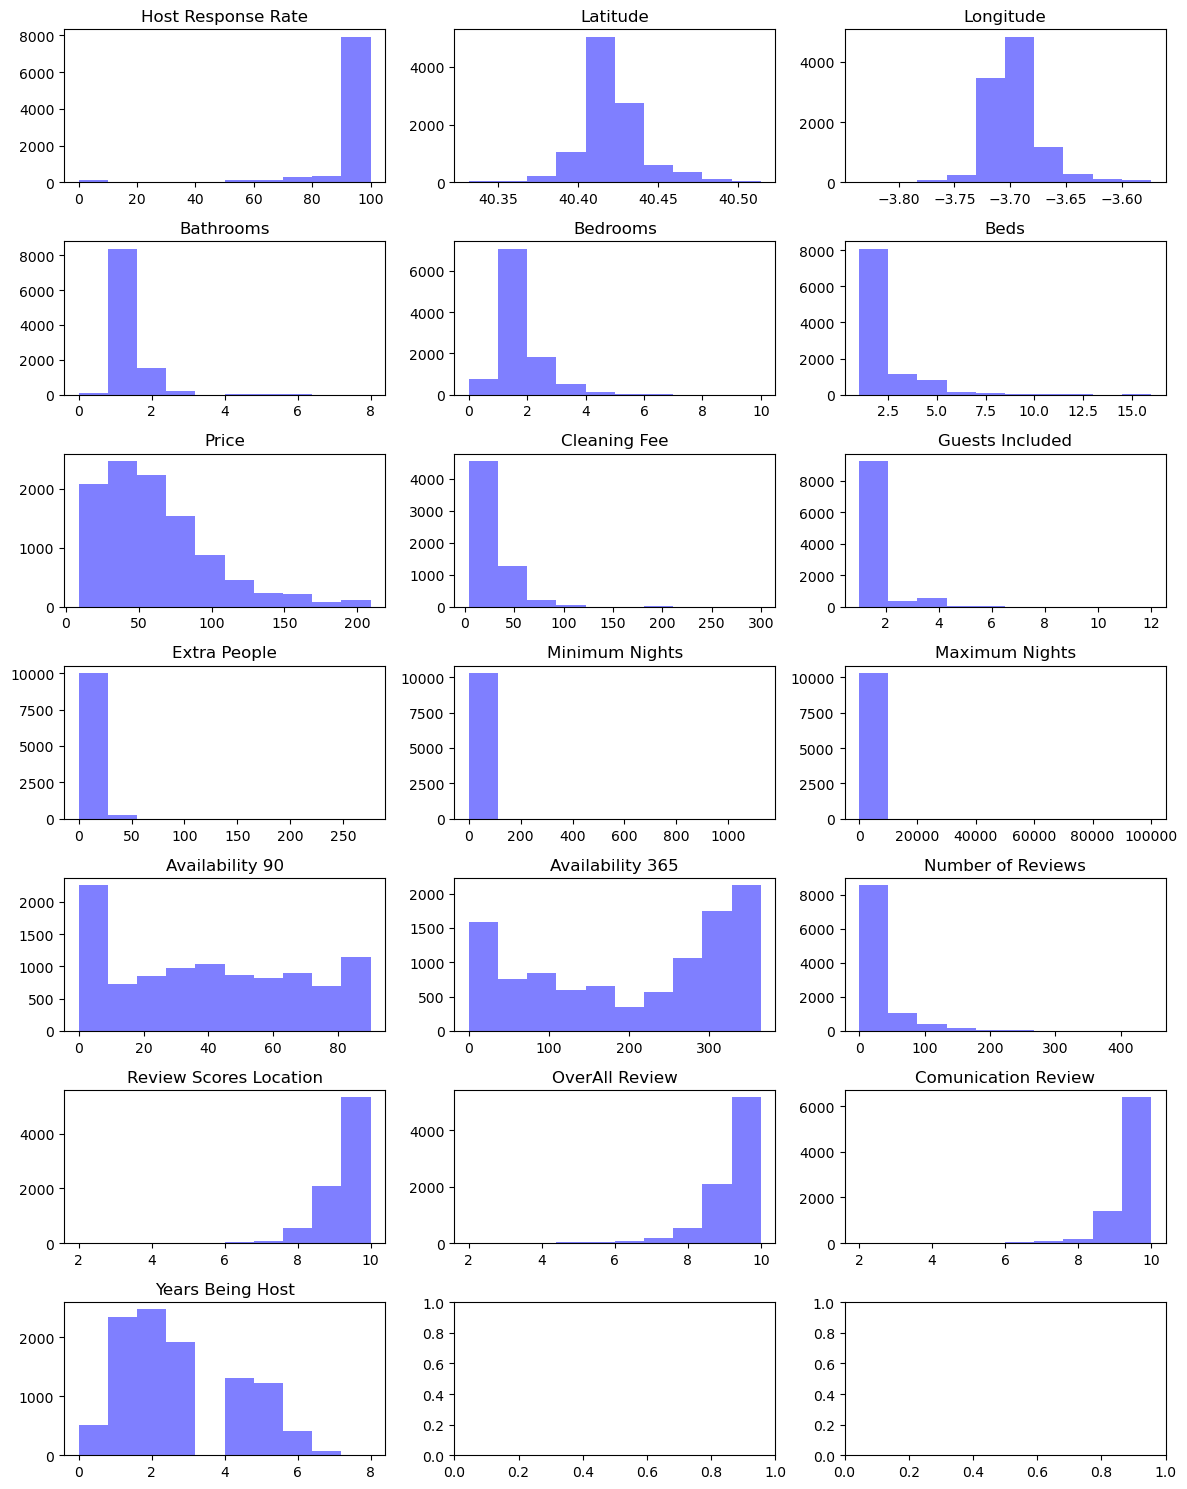

In [1917]:
# specify the number of rows and columns in the grid
nrows = 7
ncols = 3

# create the figure and axes objects
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 15))

# flatten the axes array so we can iterate over it like a list
axes = axes.flatten()

# loop through each column in the dataframe and plot a histogram on a separate axis
for i, col in enumerate(df_gen.select_dtypes(include=np.number).columns):
    axes[i].hist(df_gen[col], bins=10, color='blue', alpha=0.5)
    axes[i].set_title(col)

# adjust spacing between subplots
fig.tight_layout()

In [1918]:
print(f"Registros con cero baños: {len(df_gen[df_gen['Bathrooms'] == 0])}")
print(f"Registros con precio cero: {len(df_gen[df_gen['Price'] == 0])}")
print(f"Registros con cero Bedrooms: {len(df_gen[df_gen['Bedrooms'] == 0])}")
print(f"Registros con cero Beds: {len(df_gen[df_gen['Beds'] == 0])}")
      
#df_gen = df_gen[df_gen['Bathrooms'] != 0]
#df_gen = df_gen[df_gen['Price'] != 0]
#df_gen = df_gen[df_gen['Bedrooms'] != 0]

Registros con cero baños: 53
Registros con precio cero: 0
Registros con cero Bedrooms: 745
Registros con cero Beds: 0


Eliminamos los registros con cero baños, pero no eliminamos los registros con cero bedrooms porqeu aunque no tenga bedroom tiene bed. También eliminamod la columna Host Response Rate, Experiences Offered y Cleaning fee porque tiene muchos missing. También eliminamos la característica City porque solo nos hemos quedado con los datos de Madrid y es un modelo orientado solo a predecir los precios para Madrid.

In [1919]:
df_gen = df_gen[df_gen['Bathrooms'] != 0]
df_gen.drop(['Host Response Rate'], axis=1, inplace=True)
df_gen.drop(['Cleaning Fee'], axis=1, inplace=True)
df_gen.drop(['Experiences Offered'], axis=1, inplace=True)
df_gen.drop(['City'], axis=1, inplace=True)


Los valores missing que nos quedan son los de las reviews, porque como dijimos al inicio queremos categorizar tanto el valor de las reviews como el hecho de que un alojamiento no tenga ninguna review.

In [1920]:
num_missings = round(df_gen.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Review Scores Location    2147.0
OverAll Review            2147.0
Comunication Review       2147.0
dtype: float64

In [1921]:
print(f'Número de precios únicos: ',len(np.unique(df_gen['Review Scores Location'])))
print(f'Número de precios únicos: ',np.unique(df_gen['Review Scores Location']))

Número de precios únicos:  13
Número de precios únicos:  [ 2.          3.          4.          5.          6.          7.
  8.          8.33333333  8.66666667  9.          9.66666667 10.
         nan]


In [1922]:
values = {"Review Scores Location": -1, "OverAll Review": -1, "Comunication Review": -1}
df_gen = df_gen.fillna(value=values)

In [1923]:
print(f'Número de precios únicos: ',len(np.unique(df_gen['Review Scores Location'])))
print(f'Número de precios únicos: ',np.unique(df_gen['Review Scores Location']))

Número de precios únicos:  13
Número de precios únicos:  [-1.          2.          3.          4.          5.          6.
  7.          8.          8.33333333  8.66666667  9.          9.66666667
 10.        ]


In [1924]:
num_missings = round(df_gen.isnull().sum()).where(lambda x: x>0).dropna()
num_missings #sin missings

Series([], dtype: float64)

Ahora categoricemos las variables no numéricas  y las reviews que las trateremos como si fueran no numéricas. Aplicamos un  additive smoothing extraído 
del tutorial de Max Halford(https://maxhalford.github.io/blog/target-encoding-done-the-right-way/). A cada categoria de una variable le vamos a aplicar la media de la variable objetivo (Price) para dicho subset suavizado por la media de Price global.

In [1925]:
list(df_gen.select_dtypes(include=['object']).columns)

['Neighbourhood Group Cleansed',
 'Zipcode',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy']

In [1926]:
df_gen['Review Scores Location'].dtype

dtype('float64')

Redondeamos las reviews a la unidad para tratarlos cposteriormente como categorias

In [1927]:
#df_gen['Review Scores Location'] = pd.Series([round(val,1) for val in df_gen['Review Scores Location']])
#df_gen['OverAll Review'] = pd.Series([round(val,1) for val in df_gen['OverAll Review']])
#df_gen['Comunication Review'] = pd.Series([round(val,1) for val in df_gen['Comunication Review']])

decimals = pd.Series([0, 0, 0], index=['Review Scores Location', 'OverAll Review', 'Comunication Review'])
df_gen = df_gen.round(decimals)

In [1928]:
print(f'Número de precios únicos: ',len(np.unique(df_gen['Review Scores Location'])))
print(f'Número de precios únicos: ',np.unique(df_gen['Review Scores Location']))

Número de precios únicos:  10
Número de precios únicos:  [-1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


Ahora vamos a crear una función para aplicar Target Encoding con  additive smoothing a las reviews. Es decir, a cada categoría desde -1 (no reviews) a 10 guardaremos en la muestra la media del precio para esa categoría suavizado con la media global con un peso 'm'. Como resultado de la función obtendremos un df que sustituirá a los valors anteriores de la característica y un diccionario con con el valor para cada categoría para aplicarlo posteriormente en test.

In [1929]:

def calc_smooth_mean(df, by, on, m):
    
    result_dict = {}
    
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
    
    # Guardamos diccionario para test
    result_dict = smooth.to_dict()
    
    # Replace each value by the according smoothed mean
    return (df[by].map(smooth), result_dict)

In [1930]:
# Aplicamos el target encoding sobre train y guardamos diccionario para test (REVIEWS)
review_score_location = calc_smooth_mean(df_gen, by='Review Scores Location', on='Price', m=50)
df_gen['Review Scores Location'] = review_score_location[0]
dict_RSL_test = review_score_location[1]

OverAll_Review = calc_smooth_mean(df_gen, by='OverAll Review', on='Price', m=50)
df_gen['OverAll Review'] = OverAll_Review[0]
dict_OR_test = OverAll_Review[1]

Comunication_Review = calc_smooth_mean(df_gen, by='Comunication Review', on='Price', m=50)
df_gen['Comunication Review'] = Comunication_Review[0]
dict_CR_test = Comunication_Review[1]


In [1931]:
dict_RSL_test

{-1.0: 59.21795882534705,
 2.0: 58.79416168283826,
 3.0: 60.271677240930536,
 4.0: 58.846330929952025,
 5.0: 57.53313463013317,
 6.0: 57.10539358531511,
 7.0: 48.49881589579883,
 8.0: 48.47665930575488,
 9.0: 53.63212706564691,
 10.0: 65.0820472932825}

In [1932]:
# Comparamos con df para ver que cuadra
print(f'Número de precios únicos: ',len(np.unique(df_gen['Review Scores Location'])))
print(f'Número de precios únicos: ',np.unique(df_gen['Review Scores Location']))

Número de precios únicos:  10
Número de precios únicos:  [48.47665931 48.4988159  53.63212707 57.10539359 57.53313463 58.79416168
 58.84633093 59.21795883 60.27167724 65.08204729]


In [1933]:
# Comprobamos missings
num_missings = round(df_gen.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Series([], dtype: float64)


 'Neighbourhood Group Cleansed',
 'Zipcode',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy']

In [1934]:
df_nn['Cancellation Policy'].value_counts()

strict             3910
flexible           3329
moderate           3116
super_strict_60       4
super_strict_30       2
Name: Cancellation Policy, dtype: int64

In [1935]:
# Aplicamos el target encoding sobre train y guardamos diccionario para test
# Neighbourhood_Group_Cleansed
Neighbourhood_Group_Cleansed = calc_smooth_mean(df_gen, by='Neighbourhood Group Cleansed', on='Price', m=50)
df_gen['Neighbourhood Group Cleansed'] = Neighbourhood_Group_Cleansed[0]
dict_NGC_test = Neighbourhood_Group_Cleansed[1]
# Zipcode
Zipcode = calc_smooth_mean(df_gen, by='Zipcode', on='Price', m=300)
df_gen['Zipcode'] = Zipcode[0]
dict_ZIP_test = Zipcode[1]
# Property Type
Property_Type = calc_smooth_mean(df_gen, by='Property Type', on='Price', m=300)
df_gen['Property Type'] = Property_Type[0]
dict_PT_test = Property_Type[1]
# Room Type
Room_Type = calc_smooth_mean(df_gen, by='Room Type', on='Price', m=0)
df_gen['Room Type'] = Room_Type[0]
dict_RT_test = Room_Type[1]
# Bed Type
Bed_Type = calc_smooth_mean(df_gen, by='Bed Type', on='Price', m=300)
df_gen['Bed Type'] = Bed_Type[0]
dict_BT_test = Bed_Type[1]
# Cancellation Policy
Cancellation_Policy = calc_smooth_mean(df_gen, by='Cancellation Policy', on='Price', m=300)
df_gen['Cancellation Policy'] = Cancellation_Policy[0]
dict_CP_test = Cancellation_Policy[1]

In [1936]:
print(dict_NGC_test, "\n")
print(dict_ZIP_test, "\n")
print(dict_PT_test, "\n")
print(dict_RT_test, "\n")
print(dict_BT_test, "\n")
print(dict_CP_test)

{'Arganzuela': 47.00868774374994, 'Barajas': 50.0170232962152, 'Carabanchel': 40.3151735602733, 'Centro': 67.41017164216113, 'Chamartín': 63.63592587662866, 'Chamberí': 63.15090337936934, 'Ciudad Lineal': 45.83107206767529, 'Fuencarral - El Pardo': 49.812382766791906, 'Hortaleza': 52.19174085180458, 'Latina': 38.43028776893812, 'Moncloa - Aravaca': 59.179442886341846, 'Moratalaz': 45.75096825034364, 'Puente de Vallecas': 41.225590675508855, 'Retiro': 62.222983602252434, 'Salamanca': 69.0957815749104, 'San Blas - Canillejas': 46.2473526126675, 'Tetuán': 52.376174912683275, 'Usera': 44.08136417270543, 'Vicálvaro': 49.86652025378233, 'Villa de Vallecas': 53.927712226911254, 'Villaverde': 43.6473472007879} 

{'27004': 60.149944304733374, '27013': 60.2629011153646, '28001': 68.63863450048964, '28002': 60.05129320559811, '28003': 61.92513265540944, '28004': 64.59737403628733, '28005': 63.92367919205532, '28006': 64.55246355592335, '28007': 57.96338777812448, '28008': 60.99310737205837, '2800

In [1937]:
# Esto solo sirve para mover price a la primera posición
cols = df_gen.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df_gen = df_gen[cols]

df.fillna(df.mean(), inplace=True)
df.isnull().any()

Experiences Offered             False
Host Response Rate              False
Neighbourhood Group Cleansed    False
City                            False
Zipcode                         False
Latitude                        False
Longitude                       False
Property Type                   False
Room Type                       False
Bathrooms                       False
Bedrooms                        False
Beds                            False
Bed Type                        False
Price                           False
Cleaning Fee                    False
Guests Included                 False
Extra People                    False
Minimum Nights                  False
Maximum Nights                  False
Availability 90                 False
Availability 365                False
Number of Reviews               False
Review Scores Location          False
Cancellation Policy             False
OverAll Review                  False
Comunication Review             False
Years Being 

In [1938]:
df_gen.describe()

,Price,Neighbourhood Group Cleansed,Zipcode,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,Beds,Bed Type,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 90,Availability 365,Number of Reviews,Review Scores Location,Cancellation Policy,OverAll Review,Comunication Review,Years Being Host
count,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000,10245.000000
mean,60.277111,61.157514,62.005606,40.420455,-3.697014,60.841288,60.277111,1.230259,1.254661,1.924451,60.402351,1.546315,7.280429,2.984090,888.885993,39.638263,203.665886,23.714202,60.449452,60.287968,60.368546,60.226201,2.673890
std,37.354879,9.461164,5.040189,0.020086,0.023314,2.936601,23.145650,0.540512,0.754046,1.398370,0.343578,0.979648,9.882151,13.464541,2259.854119,29.050928,127.057840,39.348131,5.455535,5.918494,2.104595,0.792890,1.610485
min,10.000000,38.430288,51.153389,40.331888,-3.835498,49.284396,28.046667,0.500000,0.000000,1.000000,58.058618,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,48.476659,52.805086,54.637602,59.217959,0.000000
25%,30.000000,52.376175,58.708245,40.409956,-3.707719,61.858966,32.410192,1.000000,1.000000,1.000000,60.455000,1.000000,0.000000,1.000000,365.000000,12.000000,81.000000,1.000000,53.632127,52.805086,59.217959,59.370196,1.000000
50%,50.000000,67.410172,63.338563,40.418458,-3.701568,61.858966,79.381812,1.000000,1.000000,1.000000,60.455000,1.000000,0.000000,2.000000,1125.000000,38.000000,244.000000,8.000000,65.082047,59.750925,59.396734,60.734538,2.000000
75%,79.000000,67.410172,64.597374,40.427715,-3.693824,61.858966,79.381812,1.000000,1.000000,2.000000,60.455000,2.000000,13.000000,3.000000,1125.000000,64.000000,319.000000,28.000000,65.082047,67.000987,62.664009,60.734538,4.000000
max,209.000000,69.095782,70.501071,40.514247,-3.573613,64.209872,79.381812,8.000000,10.000000,16.000000,60.455000,12.000000,276.000000,1125.000000,100000.000000,90.000000,365.000000,446.000000,65.082047,67.000987,62.664009,65.234332,8.000000


# 4 Construcción y validación del modelo

In [1939]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = df_gen.values

y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = df_gen.columns[1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

Con gridsearch obtenemos los parámetros óptimos para entrenar al modelo

best mean cross-validation score: -572.808
best parameters: {'alpha': 0.09412049672680665}


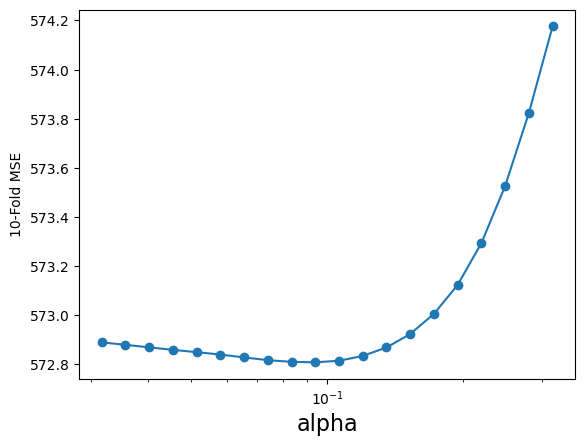

In [1940]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1.5,-0.5,20)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

In [1941]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

In [1942]:
# Eliminamos las columnas con mas del 50% de missing values en train
df_test.drop(caract_no_generables.index, axis=1, inplace=True)
print(f'dimensiones eliminadas: \n',caract_no_generables.index)

dimensiones eliminadas: 
 Index(['Notes', 'Host Acceptance Rate', 'Square Feet', 'Weekly Price',
       'Monthly Price', 'Security Deposit', 'Has Availability', 'License',
       'Jurisdiction Names'],
      dtype='object')


In [1943]:
# Nos quedamos solo con los datos de Madrid
df_test = df_test[df_test['City'] == 'Madrid']

In [1944]:
# Hacemos un drop de todas las columnas que OBVIAMENTE no aportan información relevante
not_useful_columns = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL', 'Host Name', 
    'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood', 
    'Calendar Updated', 'Calendar last Scraped', 'First Review', 
    'Last Review', 'Reviews per Month', 'Geolocation', 'Calculated host listings count',
    'Host Listings Count', 'Host Total Listings Count'
]

df_test.drop(not_useful_columns, axis=1, inplace=True)

In [1945]:
# Hacemos un drop de todas las columnas que aportando información quedan fuera del scope
somehow_useful_columns_but_droppable_anyway = ['Name', 'Summary', 'Space', 'Description',
       'Neighborhood Overview', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Host Location', 'Host About','Host Verifications', 'Features', 'Amenities'
]

df_test.drop(somehow_useful_columns_but_droppable_anyway, axis=1, inplace=True)

In [1946]:
# Eliminamos las muestras con un precio mayor a 209
df_test = df_test[df_test['Price'] <= 209]

In [1947]:
# Normalizamos
df_test["Review Scores Rating"] = df_test["Review Scores Rating"]/10

In [1948]:
# Agrupamos las características de reviews
reviews_value_rating = df_test.loc[: , ["Review Scores Rating","Review Scores Value","Review Scores Accuracy", "Review Scores Cleanliness"]]
df_test['OverAll Review'] = reviews_value_rating.mean(axis=1)

reviews_comunication = df_test.loc[: , ["Review Scores Checkin","Review Scores Communication"]]
df_test['Comunication Review'] = reviews_comunication.mean(axis=1)


df_test.drop(['Availability 30', 'Availability 60', 'Review Scores Rating','Review Scores Accuracy', "Review Scores Checkin", 
         "Review Scores Communication","Review Scores Cleanliness",
         'Review Scores Value','Accommodates'], axis=1, inplace=True)

In [1949]:
reviews =df_test[['Review Scores Location','OverAll Review','Comunication Review']]
nan_rows = reviews[reviews.isnull().any(1)]

boo_nan = nan_rows.isnull()
#conteo de columnas con nan
boo_nan['nan_colunms'] = boo_nan.sum(axis=1)

boo_nan['nan_colunms'].value_counts()

3    531
2      3
1      3
Name: nan_colunms, dtype: int64

Para las reviews que tengan uno o doz caracteristicas nan generamos caracteristica con la media de la muestra

In [1950]:
null_columns=reviews.columns[reviews.isnull().any()]
reviews[null_columns].isnull().sum()
df_reviews = reviews[reviews.isnull().any(axis=1)][null_columns]

# df conteo nan por fila
nan_rows = df_reviews[df_reviews.isnull().any(1)]
boo_nan = nan_rows.isnull()
boo_nan['nan_colunms'] = boo_nan.sum(axis=1)
boo_nan

# df merged
reviews_merge = pd.merge(df_reviews,boo_nan,left_index=True, right_index=True)

# quito las filas que todas sean missing
reviews_merge = reviews_merge[reviews_merge['nan_colunms']<3]

# calculo la media de cada fila y la asigno a los missing
columnas = [0,1,2]
for fila in range(len(reviews_merge)):
    valores=[]
    for col in columnas:
        if  False == np.isnan(reviews_merge.iloc[fila,col]):
            valores.append(reviews_merge.iloc[fila,col])
            promedio = sum(valores) / len(valores) 
    for col in columnas:
        if  np.isnan(reviews_merge.iloc[fila,col]):
            reviews_merge.iloc[fila,col] = promedio   
reviews_merge.drop(['Review Scores Location_y','OverAll Review_y','Comunication Review_y','nan_colunms'], axis=1, inplace=True)
reviews_merge.columns = ['Review Scores Location','OverAll Review','Comunication Review']
reviews_merge


,Review Scores Location,OverAll Review,Comunication Review
805,8.000000,8.000000,8.0
1013,9.666667,9.333333,10.0
1769,10.000000,10.000000,10.0
2184,10.000000,10.000000,10.0
2341,2.000000,2.000000,2.0
2474,8.000000,8.000000,8.0


In [1951]:
# Sustituimos los nan en el df original por los nuevos valores calculados
for fila in reviews_merge.index:
    #print(fila)
    fila_df_original = df_test.index.get_loc(fila)
    #print(fila_df_original)
    fila_reviews_merge = reviews_merge.index.get_loc(fila)
    #print(fila_reviews_merge)
    df_test.iloc[fila_df_original,32]=reviews_merge.iloc[fila_reviews_merge,0]
    df_test.iloc[fila_df_original,34]=reviews_merge.iloc[fila_reviews_merge,1]
    df_test.iloc[fila_df_original,35]=reviews_merge.iloc[fila_reviews_merge,2]

In [1952]:
# Comprobamos que solo quedan las muestras con 3 nan
reviews =df_test[['Review Scores Location','OverAll Review','Comunication Review']]
nan_rows = reviews[reviews.isnull().any(1)]

boo_nan = nan_rows.isnull()
#conteo de columnas con nan
boo_nan['nan_colunms'] = boo_nan.sum(axis=1)

boo_nan['nan_colunms'].value_counts()

3    531
Name: nan_colunms, dtype: int64

In [1953]:
# Nos quedamos solo con neighbourhood group cleansed
df_test.drop(["Neighbourhood", "Neighbourhood Cleansed"], axis=1, inplace=True)

In [1954]:
# calculamos años de antigüedad del host y eliminamos host since
from datetime import datetime

df_test.dropna(subset=['Host Since'], inplace=True) # se ha visto antes que solo hay tres valores missing, no se pierde mucho

df_test['Host Since'] = df_test['Host Since'].apply(lambda x: datetime.strptime(str(x),'%Y-%m-%d'))
df_test['Years Being Host'] = df_test['Host Since'].apply(lambda x: 2017 - x.year)

df_test.drop(['Host Since'], axis=1, inplace=True)

In [1955]:
df_test.drop(['Host Response Time'], axis=1, inplace=True)

In [1956]:
df_test.drop(['State'], axis=1, inplace=True)

In [1957]:
df_test['Zipcode'] = df_test['Zipcode'].replace({'Madrid 28004': '28004', '28002\n28002': '28002','28051\n28051':'28051', '2804': '28004', '2815': '28015',
                                            '2805': '28005', '28': np.nan, '2015': np.nan})
df_test['Zipcode'].value_counts()

28012    376
28004    330
28005    224
28013    219
28014    130
28015    110
28045     95
28010     83
28011     61
28028     57
28008     55
28020     41
28007     40
28006     40
28001     39
28019     39
28009     39
28003     36
28039     32
28002     30
28025     28
28017     25
28026     23
28043     23
28033     22
28029     20
28027     20
28053     19
28016     18
28042     16
28038     15
28047     14
28030     14
28021     12
28041     12
28050     12
28024     12
28036     11
28037     10
28035      9
28034      8
28018      8
28022      6
28046      5
28031      4
28023      4
28032      4
28051      3
28044      2
28049      2
28040      2
28054      2
28052      1
28055      1
25008      1
20013      1
20126      1
28056      1
Name: Zipcode, dtype: int64

In [1958]:
# Aplicamos la moda del xipcode del barrio de train a los datos de test
Neighbourhood_Group_Cleansed = df_nn['Neighbourhood Group Cleansed'].unique()
for i in Neighbourhood_Group_Cleansed:
    df_test.loc[df_test['Neighbourhood Group Cleansed'] == i, 'Zipcode'] = df_test.loc[df_test['Neighbourhood Group Cleansed'] == i, 'Zipcode'].fillna(mode_map[i])

In [1959]:
# Comprobamos missing
df_nn = df_test[list(df_test.select_dtypes(include=['object']).columns)]
num_missings = round(df_nn.isnull().sum()).where(lambda x: x>0).dropna()
num_missings

Market    14.0
dtype: float64

In [1960]:
df_test.drop(['Market'], axis=1, inplace=True)

In [1961]:
df_test.drop(['Street'], axis=1, inplace=True)
df_test.drop(['Smart Location'], axis=1, inplace=True)
df_test.drop(['Country Code'], axis=1, inplace=True)
df_test.drop(['Country'], axis=1, inplace=True)

list(df_test.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Neighbourhood Group Cleansed',
 'City',
 'Zipcode',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Cancellation Policy']

In [1962]:
df_test = df_test.dropna(subset=['Bathrooms'])
df_test = df_test.dropna(subset=['Bedrooms'])
df_test = df_test.dropna(subset=['Beds'])

In [1963]:
df_test = df_test[df_test['Bathrooms'] != 0]
df_test.drop(['Host Response Rate'], axis=1, inplace=True)
df_test.drop(['Cleaning Fee'], axis=1, inplace=True)
df_test.drop(['Experiences Offered'], axis=1, inplace=True)
df_test.drop(['City'], axis=1, inplace=True)

In [1964]:
values = {"Review Scores Location": -1, "OverAll Review": -1, "Comunication Review": -1}
df_test = df_test.fillna(value=values)

In [1965]:
#Redondeamos
decimals = pd.Series([0, 0, 0], index=['Review Scores Location', 'OverAll Review', 'Comunication Review'])
df_test = df_test.round(decimals)

In [1966]:
# Categorizamos con el diccionario de train

df_test['Review Scores Location'] = df_test['Review Scores Location'].map(dict_RSL_test)


In [1967]:
df_test['OverAll Review'] = df_test['OverAll Review'].map(dict_OR_test)
df_test['Comunication Review'] = df_test['Comunication Review'].map(dict_CR_test)
df_test['Neighbourhood Group Cleansed'] = df_test['Neighbourhood Group Cleansed'].map(dict_NGC_test)
df_test['Zipcode'] = df_test['Zipcode'].map(dict_ZIP_test)
df_test['Property Type'] = df_test['Property Type'].map(dict_PT_test)
df_test['Room Type'] = df_test['Room Type'].map(dict_RT_test)
df_test['Bed Type'] = df_test['Bed Type'].map(dict_BT_test)
df_test['Cancellation Policy'] = df_test['Cancellation Policy'].map(dict_CP_test)

In [1968]:
df_test.describe()

,Neighbourhood Group Cleansed,Zipcode,Latitude,Longitude,Property Type,Room Type,Bathrooms,Bedrooms,Beds,Bed Type,Price,Guests Included,Extra People,Minimum Nights,Maximum Nights,Availability 90,Availability 365,Number of Reviews,Review Scores Location,Cancellation Policy,OverAll Review,Comunication Review,Years Being Host
count,2520.000000,2515.000000,2520.000000,2520.000000,2519.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000,2520.000000
mean,60.876859,62.049394,40.420445,-3.697615,60.816952,60.630952,1.238492,1.261905,1.934127,60.416988,61.247619,1.580952,7.658333,2.840476,1253.406349,40.077381,205.601587,22.146825,60.430586,60.072188,60.364200,60.222537,2.719048
std,9.728120,5.214711,0.020142,0.023115,3.011389,23.069876,0.568166,0.756904,1.386011,0.296548,38.625108,1.118520,10.700121,8.428196,19919.543129,29.465814,127.476086,35.173565,5.445260,5.865135,2.138665,0.784374,1.645556
min,38.430288,51.153389,40.341713,-3.785982,49.284396,28.046667,0.500000,0.000000,1.000000,58.058618,9.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,48.476659,52.805086,54.637602,59.217959,0.000000
25%,52.376175,57.979922,40.410000,-3.707927,61.858966,32.410192,1.000000,1.000000,1.000000,60.455000,30.750000,1.000000,0.000000,1.000000,365.000000,12.000000,81.000000,1.000000,53.632127,52.805086,59.217959,59.370196,1.000000
50%,67.410172,63.338563,40.418305,-3.701858,61.858966,79.381812,1.000000,1.000000,2.000000,60.455000,51.000000,1.000000,5.000000,2.000000,1125.000000,38.000000,249.000000,8.000000,65.082047,59.750925,59.396734,60.734538,2.000000
75%,67.410172,64.597374,40.427582,-3.694155,61.858966,79.381812,1.000000,1.000000,2.000000,60.455000,80.000000,2.000000,15.000000,3.000000,1125.000000,65.000000,322.000000,28.000000,65.082047,67.000987,62.664009,60.734538,4.000000
max,69.095782,70.501071,40.513552,-3.576992,64.209872,79.381812,6.000000,10.000000,16.000000,60.455000,207.000000,16.000000,271.000000,365.000000,1000000.000000,90.000000,365.000000,339.000000,65.082047,67.000987,62.664009,65.234332,8.000000


In [1969]:
cols = df_test.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df_test = df_test[cols]

df_test.fillna(df_gen.mean(), inplace=True)

In [1970]:
print(df_gen.shape, df_test.shape)

(10245, 23) (2520, 23)


In [1971]:
data_test = df_test.values

y_test = data_test[:,0:1]     # nos quedamos con la 1ª columna, price
X_test = data_test[:,1:]      # nos quedamos con el resto

feature_names_test = df_test.columns[1:]

# recordad que esta normalización/escalado la realizo con el scaler anterior, basado en los datos de training!
XtestScaled = scaler.transform(X_test) 

Regularizamos con lasso con los parámetros óptimos obtenidos por Gridsearch y calculamos los coeficientes:

In [1972]:
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']#*10 #*100
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.5g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.5g' % mseTestModelLasso)

w = lasso.coef_
for f,wi in zip(feature_names,w):
    print(f,wi)

MSE Modelo Lasso (train): 569.47
MSE Modelo Lasso (test) : 599.13
Neighbourhood Group Cleansed 3.35384069588935
Zipcode 3.7823572419181644
Latitude 0.8870475884772909
Longitude 0.08112418391379513
Property Type -0.35071747946041104
Room Type 18.178527348502897
Bathrooms 3.3125377640747256
Bedrooms 9.553930319576898
Beds 2.92547289777839
Bed Type 0.5077461977164663
Guests Included 3.6917907148520976
Extra People -1.2560500258513805
Minimum Nights -0.32755671827970056
Maximum Nights 0.0
Availability 90 2.2958140242323837
Availability 365 1.5300135162331028
Number of Reviews -4.042655920997858
Review Scores Location 1.5029089178766972
Cancellation Policy -0.012940991206306618
OverAll Review 2.6471540234890463
Comunication Review -2.27588006251506
Years Being Host 1.5564462899168139


Buscamos la mejor combinanciṕn de parémetros para el modelo GradientBoostingRegresor:

In [1973]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [500, 1000, 5000, 8000]
learningRate = [0.1, 0.01]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.710
best parameters: {'learning_rate': 0.01, 'n_estimators': 5000}


Aplicamos al modelo la mejor combinación de parámetros encontrados por GridSearch:
Obtenemos una accuracy muy similar para train y test, lo que es un buen indicador.

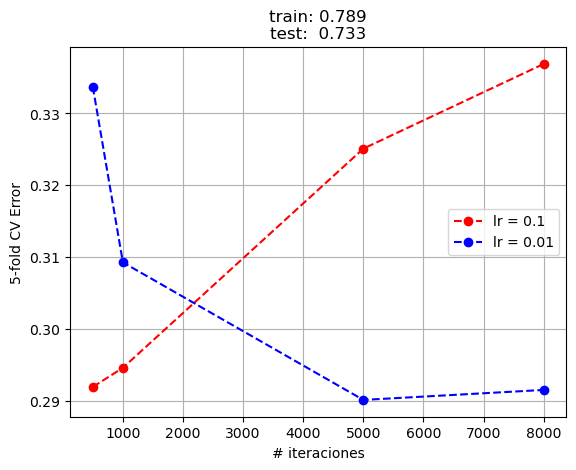

In [1974]:
learning_rate = grid.best_params_['learning_rate']
NEstimators = grid.best_params_['n_estimators']

bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=learning_rate, n_estimators=NEstimators)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

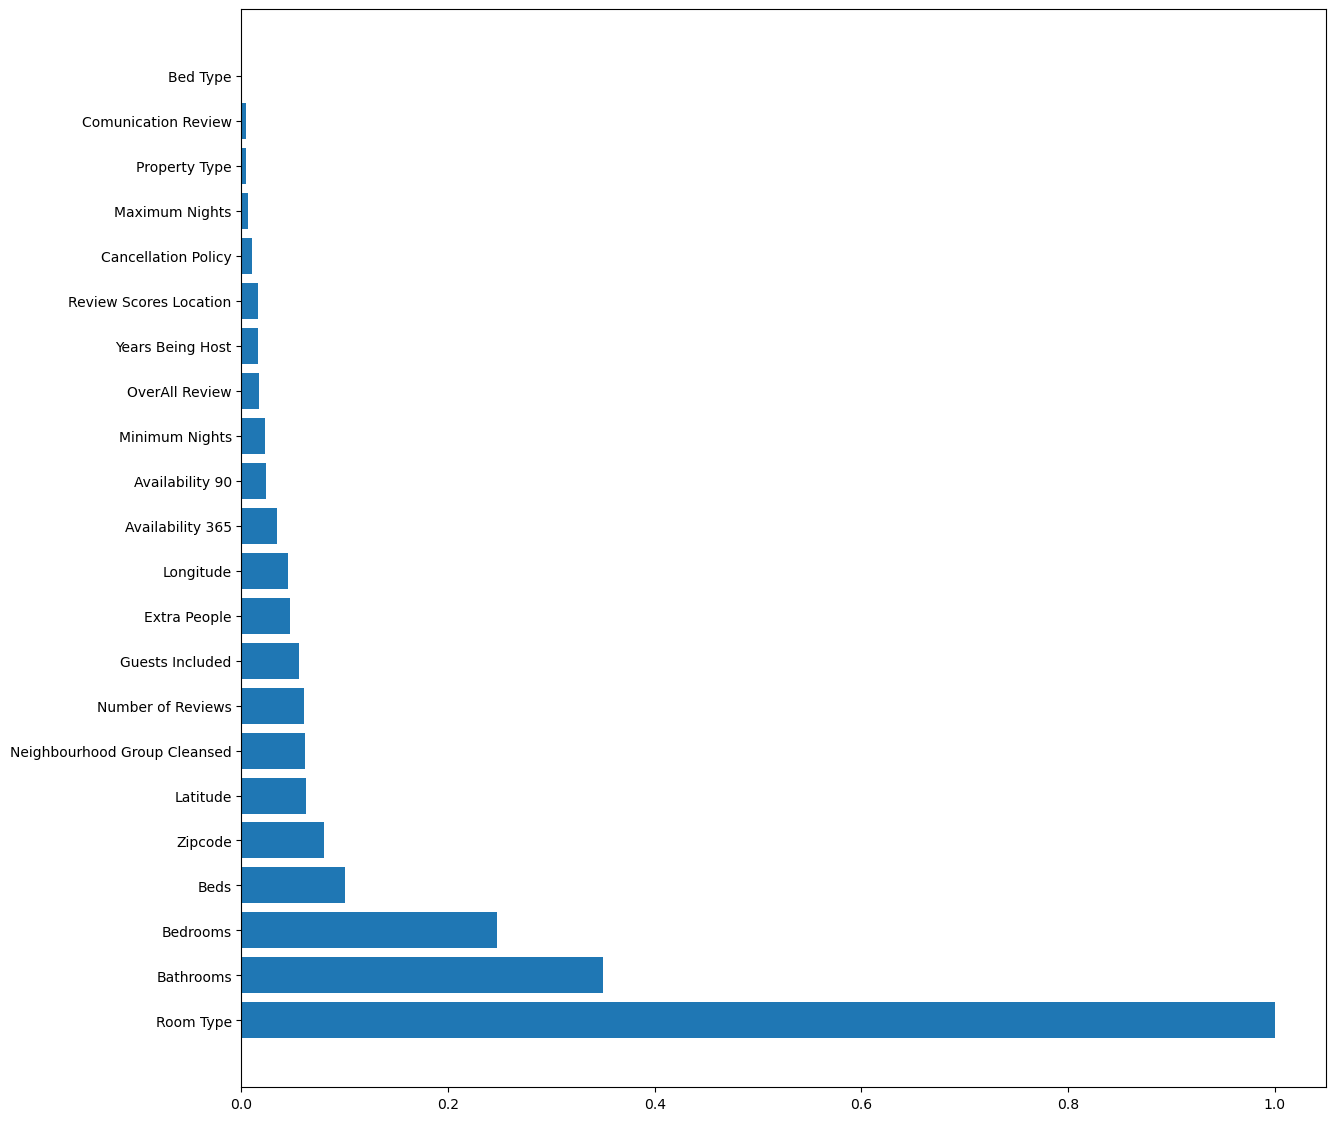

In [1975]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(14,14))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()